In [1]:
%load_ext autoreload
%autoreload 2

import sklearn.linear_model as linear_model

In [2]:
import pandas as pd

# read from txt file to pandas
data_path = '/Users/laabidn1/Modeling-Biological-Networks-Assignment/data/data.txt'
data = pd.read_csv(data_path, sep=' ', header=0)

In [3]:
data.values

array([[0.076 , 0.0419, 0.0207, 0.0225, 0.1033],
       [0.0186, 0.0365, 0.0122, 0.0175, 0.0462],
       [0.009 , 0.0514, 0.0073, 0.0165, 0.0439],
       [0.0117, 0.0473, 0.0079, 0.0147, 0.0371],
       [0.0088, 0.0482, 0.0084, 0.0145, 0.0475],
       [0.0095, 0.0546, 0.01  , 0.0144, 0.0468],
       [0.0075, 0.0648, 0.0096, 0.0106, 0.0347],
       [0.007 , 0.0552, 0.0107, 0.0119, 0.0247],
       [0.0081, 0.0497, 0.0113, 0.0104, 0.0269],
       [0.0057, 0.0352, 0.0116, 0.0142, 0.019 ],
       [0.0052, 0.0358, 0.0073, 0.0084, 0.0134],
       [0.0093, 0.0338, 0.0075, 0.0097, 0.0148],
       [0.0055, 0.0309, 0.0082, 0.0088, 0.0101],
       [0.006 , 0.0232, 0.0078, 0.0087, 0.0088],
       [0.0069, 0.0191, 0.0089, 0.0086, 0.008 ],
       [0.0093, 0.019 , 0.0104, 0.011 , 0.009 ],
       [0.009 , 0.0176, 0.0114, 0.0124, 0.0113],
       [0.0129, 0.0105, 0.01  , 0.0093, 0.0154],
       [0.0022, 0.0081, 0.0086, 0.0079, 0.003 ],
       [0.0018, 0.0072, 0.0078, 0.0103, 0.0012]])

In [4]:
X = data.iloc[:-1]
Y = data.iloc[1:]

In [28]:
gene_names = list(data.columns.values)
model_true_model = {
    'SWI5': [None, 1, 0, 1, 1],
    'CBF1': [0, None, 1, 0, 0],
    'GAL4': [1, 0, None, -0.5, 0],
    'GAL80': [0, 0, -0.5, None, 0],
    'ASH1': [0, -1, 0, 0, None]
}

# dataframe from python dict
model_true = pd.DataFrame(model_true_model, index=gene_names)
true_structure = (model_true.fillna(0)!=0).values.flatten()
true_structure

array([False, False,  True, False, False,  True, False, False, False,
        True, False,  True, False,  True, False,  True, False,  True,
       False, False,  True, False, False, False, False])

# Linear Regression

In [5]:
lasso = linear_model.Ridge(alpha=0.8, fit_intercept=False)
out = lasso.fit(X,Y)
lasso.coef_

array([[0.00303663, 0.00679496, 0.00194015, 0.00241719, 0.00621076],
       [0.00944903, 0.0328532 , 0.00758593, 0.00997747, 0.02584531],
       [0.00267768, 0.0075731 , 0.00213195, 0.00255545, 0.00591595],
       [0.00361812, 0.00967138, 0.00266273, 0.00332064, 0.00815076],
       [0.00831151, 0.02139565, 0.00522627, 0.00706757, 0.02008124]])

In [6]:
# infer structure from weights...
# arrow exists if weight is non-zero
coefficients = lasso.coef_
structure = (coefficients!=0).flatten()

# indices: all pairs in order


In [7]:
nb_genes = data.shape[1]
gene_names = list(data.columns.values)
pairs = [(gene_names[a],gene_names[b]) for a in range(nb_genes) for b in range(nb_genes)]
len(structure)==len(pairs)

True

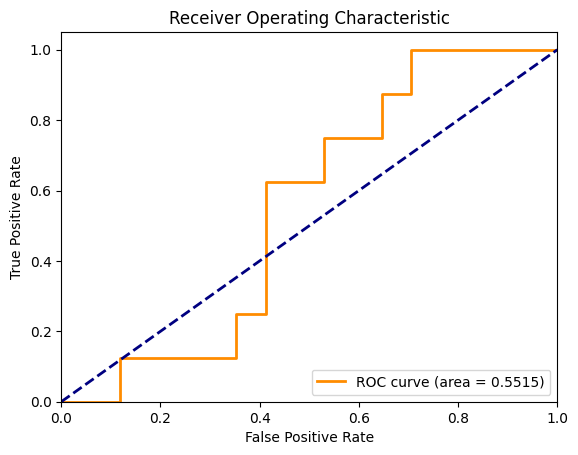

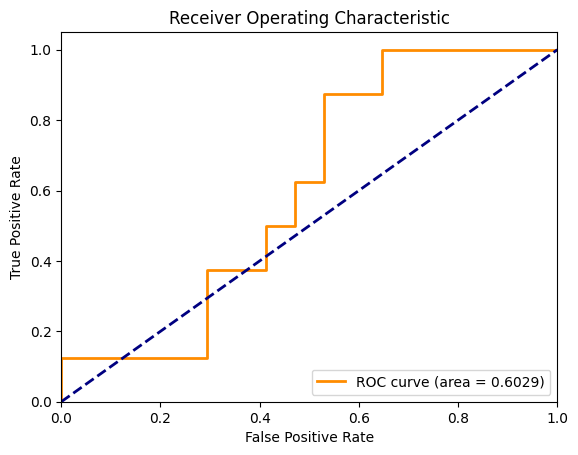

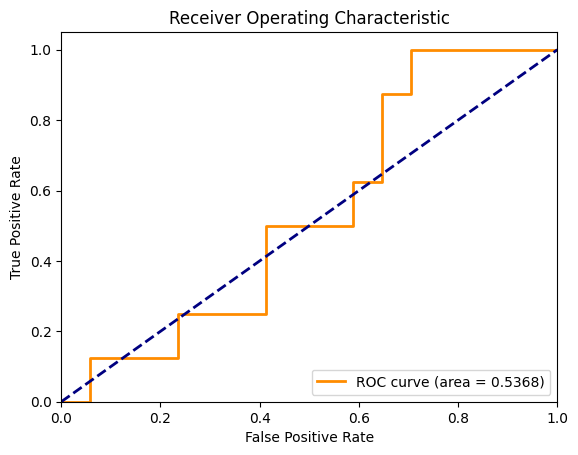

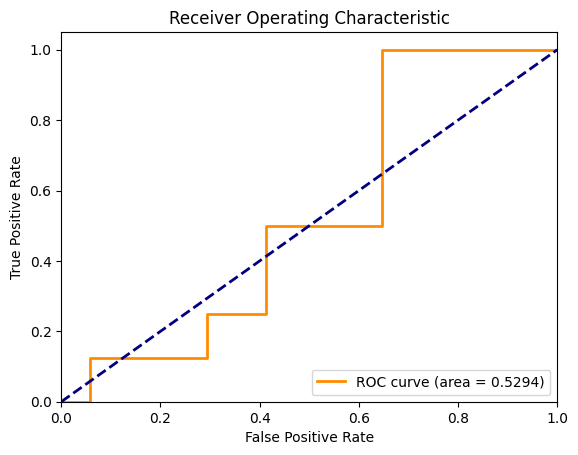

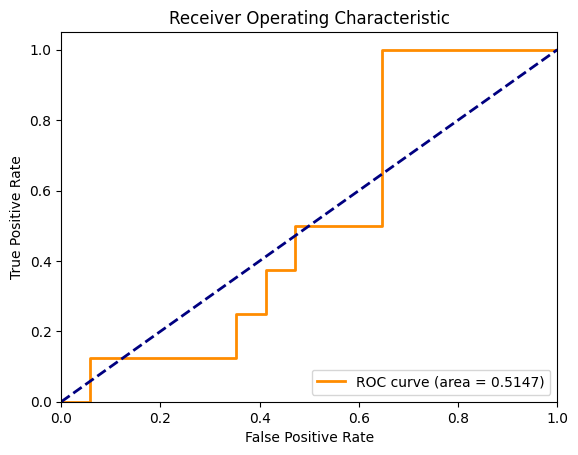

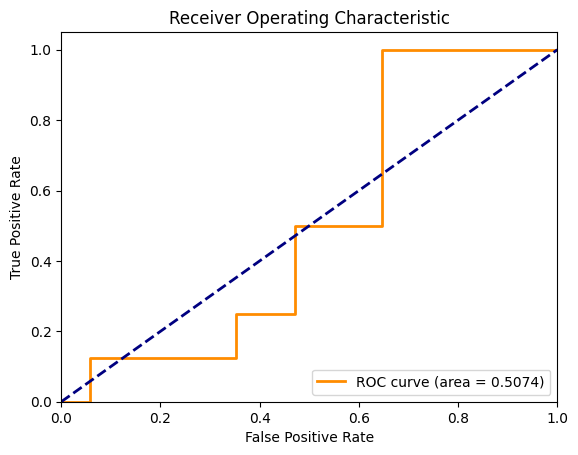

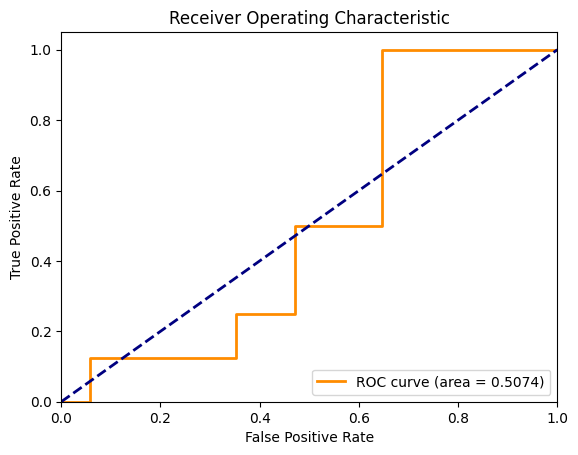

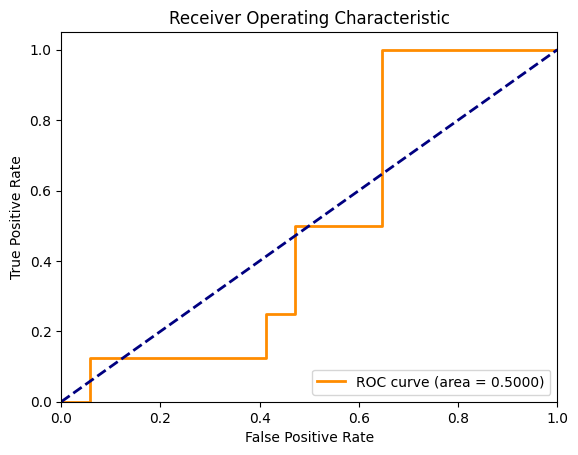

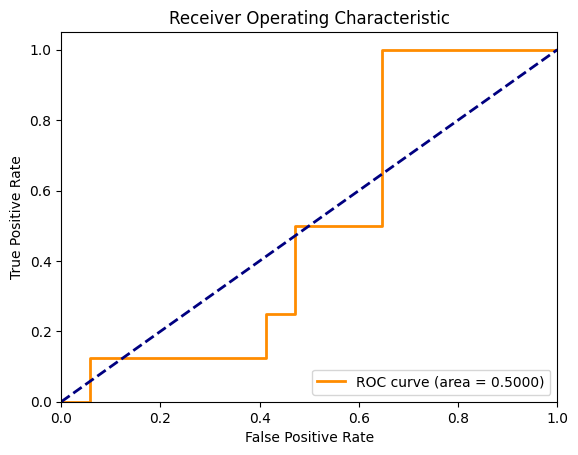

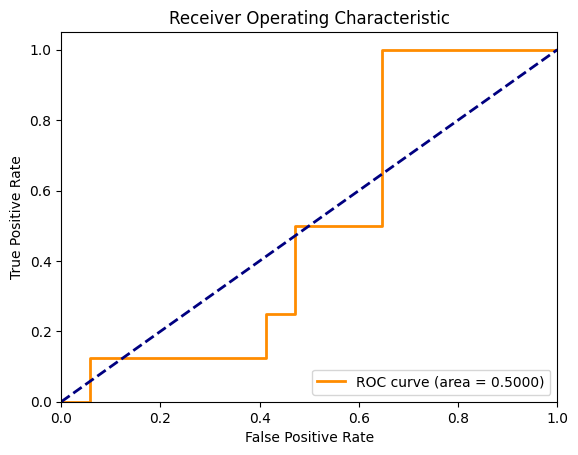

In [10]:
# compute tpr and fpr using sklearn
from sklearn.metrics import roc_curve, auc
import numpy as np

alphas = np.linspace(0, 0.1, 10)

for alpha in alphas:
    #print(f'alpha: {alpha}\n')
    lasso = linear_model.Ridge(alpha=alpha, fit_intercept=False)
    out = lasso.fit(X,Y)
    coefficients = lasso.coef_
    #print(f'cofficients: {coefficients}\n')
    
    coefficients[range(5),range(5)] = 0
    #print(f'np.abs(coefficients.T.flatten()) {np.abs(coefficients.T.flatten())}')
    #print(np.abs(coefficients.T.flatten()).argsort())
    fpr, tpr, thresholds = roc_curve(true_structure, np.abs(coefficients.T.flatten()))
    # compute fpr and tpr for 
    #print(f'fpr: {fpr}\n')
    roc_auc = auc(fpr, tpr)

    # plot roc curve
    import matplotlib.pyplot as plt
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.4f)' % roc_auc)
    # add the random line
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()
#     i = input('press enter to continue')
#     if i == 'q':
#         break


In [22]:
# create a linear model with a single layer in pytorch
import torch
import torch.nn as nn
import torch.optim as optim
from torchdiffeq import odeint

class LinearModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(input_size, output_size, bias=False)
        
    def ode_function(self, t, x):
        return self.linear(x)
        
    def forward(self, x):
        # return self.linear(x)
        # define the forward function as an ODE
        t = torch.linspace(0, 10, 10)

        # Solve the ODE
        solution = odeint(self.ode_function, y0=x, t=t)
        
        return solution[-1]
    
class AdvancedModel(nn.Module):
    def __init__(self, input_size, output_size, hidden_size):
        super(AdvancedModel, self).__init__()
        self.linear = nn.Linear(input_size, hidden_size)
        self.activation = nn.ReLU()
        self.linear2 = nn.Linear(hidden_size, output_size, bias=False)
        
    def ode_function(self, t, x):
        xt = self.linear(x)
        xt = self.activation(xt)
        return self.linear2(xt)
    
        # return self.linear(x)
        
    def forward(self, x):
        # return self.linear(x)
        # define the forward function as an ODE
        t = torch.linspace(0, 10, 10)

        # Solve the ODE
        solution = odeint(self.ode_function, y0=x, t=t)
        
        return solution[-1]
    
# define a simple GNN from torch_geometric
   

Inferred Interaction Matrix:
[[0.30114004 0.40614706 0.46228343 0.50737166 0.5369514 ]
 [0.40614706 0.56850463 0.64773077 0.7106964  0.753439  ]
 [0.46228343 0.64773077 0.7386631  0.810662   0.85932183]
 [0.50737166 0.7106964  0.810662   0.8898272  0.9432371 ]
 [0.5369514  0.753439   0.85932183 0.9432371  1.        ]]


In [21]:
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt

class XYDataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.tensor(x.values, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

# Assume df_x and df_y are your DataFrames for features and targets
dataset = XYDataset(X, Y)

train_loader = DataLoader(dataset, batch_size=32, shuffle=True)
#train_loader = torch.utils.data.DataLoader(data.values, batch_size=4, shuffle=True, num_workers=2)

alphas = np.linspace(0, 1., 2)
for alpha in alphas:
    # define the training code
    #epochs = 40000
    epochs = 4000
    # net = LinearModel(5,5) # +1 for time
    net = AdvancedModel(5,5,10) # +1 for time
    criterion = nn.MSELoss()
    #optimizer = optim.SGD(net.parameters(), lr=1., momentum=0.9)
    optimizer = optim.Adam(net.parameters(), lr=0.01)

    for epoch in range(epochs):
        for i, batch in enumerate(train_loader):
            inputs, labels = batch
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels) + alpha*net.linear.weight.norm(2)**2
            loss.backward()
            optimizer.step()

        print('Epoch %d, loss: %.6f' % (epoch + 1, loss.item()))
        
    th = 1e-8
    weights = net.linear.weight.detach().numpy()
    weights[range(5),range(5)] = 0
    structure = np.abs(weights)>th
    
    # compute tpr and fpr using sklearn
    fpr, tpr, thresholds = roc_curve(true_structure, np.abs(weights.T.flatten()))
    roc_auc = auc(fpr, tpr)

    # plot roc curve
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    # add the random line
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()



Epoch 1, loss: 3.507392
Epoch 2, loss: 1.894883
Epoch 3, loss: 1.078511
Epoch 4, loss: 0.685053
Epoch 5, loss: 0.485523
Epoch 6, loss: 0.366552
Epoch 7, loss: 0.284984
Epoch 8, loss: 0.225945
Epoch 9, loss: 0.181854
Epoch 10, loss: 0.148112
Epoch 11, loss: 0.121919
Epoch 12, loss: 0.101378
Epoch 13, loss: 0.085184
Epoch 14, loss: 0.076016
Epoch 15, loss: 0.069495
Epoch 16, loss: 0.063534
Epoch 17, loss: 0.057787
Epoch 18, loss: 0.052260
Epoch 19, loss: 0.047062
Epoch 20, loss: 0.042303
Epoch 21, loss: 0.038052
Epoch 22, loss: 0.034336
Epoch 23, loss: 0.031140
Epoch 24, loss: 0.028425
Epoch 25, loss: 0.026136
Epoch 26, loss: 0.024165
Epoch 27, loss: 0.022169
Epoch 28, loss: 0.019326
Epoch 29, loss: 0.016821
Epoch 30, loss: 0.017495
Epoch 31, loss: 0.014859
Epoch 32, loss: 0.013632
Epoch 33, loss: 0.013290
Epoch 34, loss: 0.012783
Epoch 35, loss: 0.011892
Epoch 36, loss: 0.010712
Epoch 37, loss: 0.009569
Epoch 38, loss: 0.008647
Epoch 39, loss: 0.007967
Epoch 40, loss: 0.007348
Epoch 41,

ValueError: Found input variables with inconsistent numbers of samples: [25, 50]

# Using a GNN

In [16]:
import torch
from torch_geometric.data import Dataset, Data

class DirectGraphTranslationDataset(Dataset):
    def __init__(self, input_graphs, output_graphs, num_nodes, transform=None, pre_transform=None):
        """
        input_graphs and output_graphs are lists of tuples, where each tuple contains
        the edge_index tensor and the node features tensor (x) for a graph.
        Example: input_graphs = [(edge_index1, x1), (edge_index2, x2), ...]
        """
        self.num_nodes = num_nodes
        self.input_graphs = input_graphs
        self.output_graphs = output_graphs
        super(DirectGraphTranslationDataset, self).__init__('.', transform, pre_transform)
        self.data_list = self.process_data_list()

    def process_data_list(self):
        data_list = []
        for input_graph, output_graph in zip(self.input_graphs, self.output_graphs):
            input_edge_index, input_x = input_graph
            output_edge_index, output_x = output_graph
            data = Data(edge_index=input_edge_index, x=input_x, output_edge_index=output_edge_index, output_x=output_x)
            data_list.append(data)
        return data_list

    def len(self):
        return len(self.data_list)

    def get(self, idx):
        return self.data_list[idx]

    @property
    def processed_file_names(self):
        # Override this method to avoid unnecessary file checks
        return ['dummy.pt']

# Example data: 5 genes, hence 5 nodes, with random features and a dummy edge_index
num_nodes = X.shape[1]
num_node_features = 1  # Arbitrary number of features per node
num_classes = 5  # Output features, can be used to infer interactions indirectly

# Define edges (fully connected for illustration)
edge_index = torch.combinations(torch.arange(0, num_nodes), r=2, with_replacement=False).t()

# Create a PyG data object
input_graphs = [(edge_index, x.unsqueeze(-1)) for x in torch.tensor(X.values).float()]
output_graphs = [(edge_index, y.unsqueeze(-1)) for y in torch.tensor(Y.values).float()]

# Initialize the dataset with your data
dataset = DirectGraphTranslationDataset(input_graphs, output_graphs, num_nodes)

# Use the dataset with a DataLoader
from torch_geometric.loader import DataLoader

train_loader = DataLoader(dataset, batch_size=2, shuffle=True)

In [22]:
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import numpy as np
import torch.nn as nn
import torch.optim as optim

# Define a simple GCN model
class SimpleGCN(torch.nn.Module):
    def __init__(self, num_node_features, num_classes):
        super(SimpleGCN, self).__init__()
        self.conv1 = GCNConv(num_node_features, 16)
        self.conv2 = GCNConv(16, num_classes)

    def forward(self, x, edge_index):
        x = torch.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

# Initialize the model
model = SimpleGCN(1, 1)

epochs = 200
criterion = nn.MSELoss()
#optimizer = optim.SGD(net.parameters(), lr=1., momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(epochs):
    for i, batch in enumerate(train_loader):
        optimizer.zero_grad()
        # print(f'batch.output_x: {batch.output_x}\n')
        # print(f'batch.x: {batch.x}, batch.edge_index: {batch.edge_index}\n')
        # print(f'size of batch.x: {batch.x.shape}, size of batch.edge_index: {batch.edge_index.shape}\n')

        outputs = model(x=batch.x, edge_index=batch.edge_index)
        # print(f'outputs: {outputs}\n')
        loss = criterion(batch.output_x, outputs)
        loss.backward()
        optimizer.step()

    print('Epoch %d, loss: %.6f' % (epoch + 1, loss.item()))

Epoch 1, loss: 0.000258
Epoch 2, loss: 0.000474
Epoch 3, loss: 0.000010
Epoch 4, loss: 0.000252
Epoch 5, loss: 0.000285
Epoch 6, loss: 0.000424
Epoch 7, loss: 0.000010
Epoch 8, loss: 0.000021
Epoch 9, loss: 0.000336
Epoch 10, loss: 0.000129
Epoch 11, loss: 0.000546
Epoch 12, loss: 0.000161
Epoch 13, loss: 0.000016
Epoch 14, loss: 0.000014
Epoch 15, loss: 0.000056
Epoch 16, loss: 0.000336
Epoch 17, loss: 0.000105
Epoch 18, loss: 0.000110
Epoch 19, loss: 0.000357
Epoch 20, loss: 0.000330
Epoch 21, loss: 0.000110
Epoch 22, loss: 0.000512
Epoch 23, loss: 0.000104
Epoch 24, loss: 0.000018
Epoch 25, loss: 0.000278
Epoch 26, loss: 0.000319
Epoch 27, loss: 0.000094
Epoch 28, loss: 0.000435
Epoch 29, loss: 0.000016
Epoch 30, loss: 0.000121
Epoch 31, loss: 0.000062
Epoch 32, loss: 0.000118
Epoch 33, loss: 0.000019
Epoch 34, loss: 0.000457
Epoch 35, loss: 0.000027
Epoch 36, loss: 0.000218
Epoch 37, loss: 0.000088
Epoch 38, loss: 0.000122
Epoch 39, loss: 0.000033
Epoch 40, loss: 0.000470
Epoch 41,

In [26]:
model.eval()  # Set the model to evaluation mode

# Placeholder for storing all similarity matrices from each batch
all_similarity_matrices = []

train_loader = DataLoader(dataset, batch_size=1, shuffle=True)
batch = [b for b in train_loader][0]

with torch.no_grad():  # No gradients needed for inference
    out = model(batch.x, batch.edge_index)  # Forward pass for each batch

    # Compute similarity matrix for the current batch
    similarity_matrix = torch.mm(out, out.t())
    normalized_similarity = similarity_matrix / similarity_matrix.max()

normalized_similarity

tensor([[0.5692, 0.6534, 0.6994, 0.7317, 0.7544],
        [0.6534, 0.7500, 0.8028, 0.8399, 0.8660],
        [0.6994, 0.8028, 0.8593, 0.8990, 0.9270],
        [0.7317, 0.8399, 0.8990, 0.9406, 0.9699],
        [0.7544, 0.8660, 0.9270, 0.9699, 1.0000]])

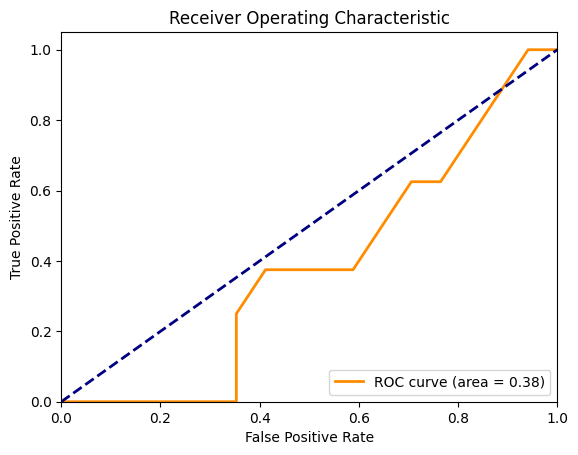

In [29]:
from sklearn.metrics import roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt

# compute tpr and fpr using sklearn
fpr, tpr, thresholds = roc_curve(true_structure, np.abs(normalized_similarity.T.flatten()))
roc_auc = auc(fpr, tpr)

# plot roc curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
# add the random line
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
